In [63]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Fetch BTC trade raw data
BTC_raw = yf.download('BTC-USD', start='2021-01-01', end='2023-04-19')
# BTC_raw.columns = ['date', 'open_price', 'high', 'low', 'close_price', 'adj close', 'volume']
BTC_raw.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [40]:
"""
for i in range(20):
  BTC_raw = BTC_raw.append(pd.Series([BTC_raw.iloc[-1][0] + pd.DateOffset(days=1),None,None,None,None,None,None], index=['Date','Open','High','Low','Close','Adj Close','Volume']),ignore_index=True)
BTC_raw
"""

"\nfor i in range(20):\n  BTC_raw = BTC_raw.append(pd.Series([BTC_raw.iloc[-1][0] + pd.DateOffset(days=1),None,None,None,None,None,None], index=['Date','Open','High','Low','Close','Adj Close','Volume']),ignore_index=True)\nBTC_raw\n"

In [41]:
# Split the raw data into parts
BTC_basic = BTC_raw[['Adj Close', 'Open']]
BTC_quant = BTC_raw
BTC_quant

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,30485.699219,22659995079
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,30318.496094,11940685378
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,30315.355469,12854816417


Text(0, 0.5, 'Prices ($)')

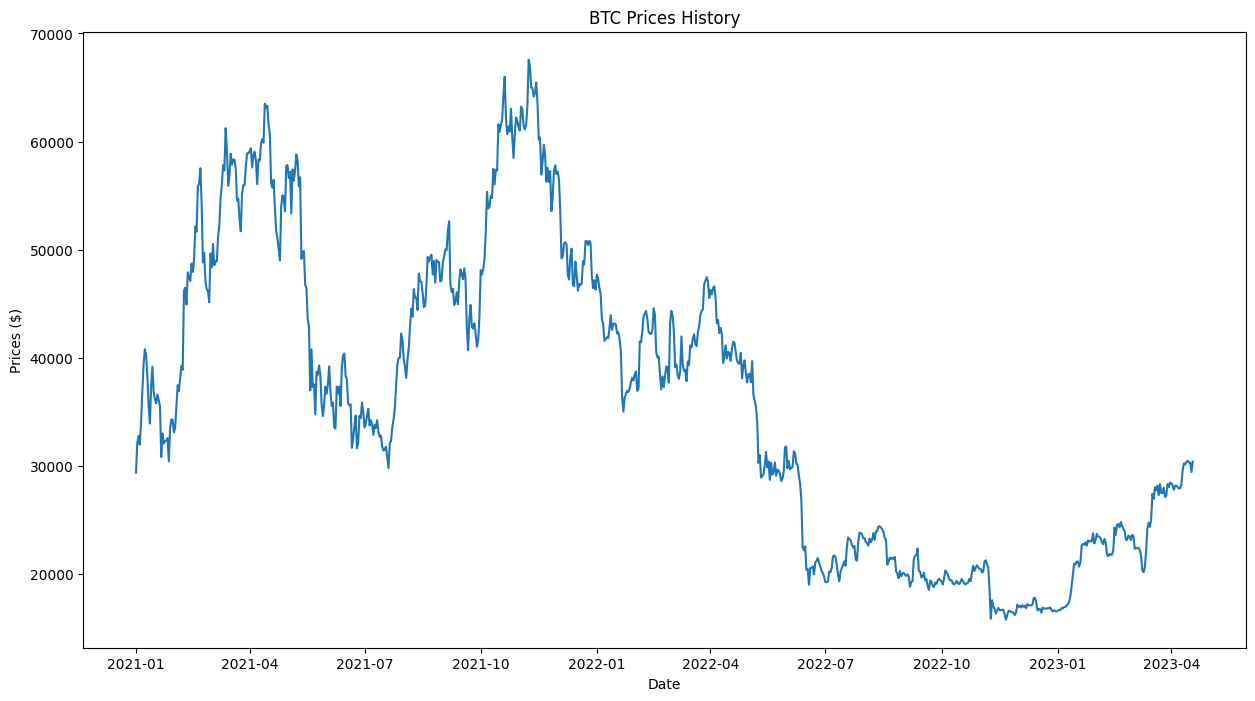

In [42]:
plt.figure(figsize=(15, 8))
plt.title('BTC Prices History')
plt.plot(BTC_quant['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [43]:
### Preparing training set (80%) ###
x_train = []
y_train = []
# Extract close price
close_price = BTC_quant['Adj Close']
training_data_len = math.ceil(len(close_price.values)* 0.8)
# Normalised data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.values.reshape(-1,1))
training_data = scaled_data[0: training_data_len, :]

In [44]:
### Create a price window with 30 days ###
window_size = 30
for i in range(window_size, len(training_data)):
    x_train.append(training_data[i-window_size:i, 0])
    y_train.append(training_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [45]:
### Preparing testing set (20%) ###
test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = close_price.values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [46]:
y_test

array([20209.98828125, 21147.23046875, 21282.69140625, 20926.48632812,
       20602.81640625, 18541.27148438, 15880.78027344, 17586.77148438,
       17034.29296875, 16799.18554688, 16353.36523438, 16618.19921875,
       16884.61328125, 16669.43945312, 16687.51757812, 16697.77734375,
       16711.546875  , 16291.83203125, 15787.28417969, 16189.76953125,
       16610.70703125, 16604.46484375, 16521.84179688, 16464.28125   ,
       16444.62695312, 16217.32226562, 16444.98242188, 17168.56640625,
       16967.1328125 , 17088.66015625, 16908.23632812, 17130.48632812,
       16974.82617188, 17089.50390625, 16848.12695312, 17233.47460938,
       17133.15234375, 17128.72460938, 17104.19335938, 17206.4375    ,
       17781.31835938, 17815.65039062, 17364.86523438, 16647.484375  ,
       16795.09179688, 16757.9765625 , 16439.6796875 , 16906.3046875 ,
       16817.53515625, 16830.34179688, 16796.953125  , 16847.75585938,
       16841.98632812, 16919.8046875 , 16717.17382812, 16552.57226562,
      

In [47]:
### Set up LSTM architecture ###
model = keras.Sequential()
model.add(layers.LSTM(250, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(250, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 250)           252000    
                                                                 
 lstm_5 (LSTM)               (None, 250)               501000    
                                                                 
 dense_4 (Dense)             (None, 25)                6275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 759,301
Trainable params: 759,301
Non-trainable params: 0
_________________________________________________________________


In [48]:
### Traning ###
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=50)

Epoch 1/50
641/641 [==============================] - 7s 6ms/step - loss: 0.0063
Epoch 2/50
641/641 [==============================] - 4s 7ms/step - loss: 0.0028
Epoch 3/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0022
Epoch 4/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 5/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 6/50
641/641 [==============================] - 5s 7ms/step - loss: 0.0018
Epoch 7/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0017
Epoch 8/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 9/50
641/641 [==============================] - 5s 8ms/step - loss: 0.0016
Epoch 10/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0017
Epoch 11/50
641/641 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 12/50
641/641 [==============================] - 4s 7ms/step - loss: 0.0019
Epoch 13/50
641/641 [====

In [49]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6/6 [==============================] - 1s 4ms/step


496.3463346744012

<ipython-input-51-40cadf09f6da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


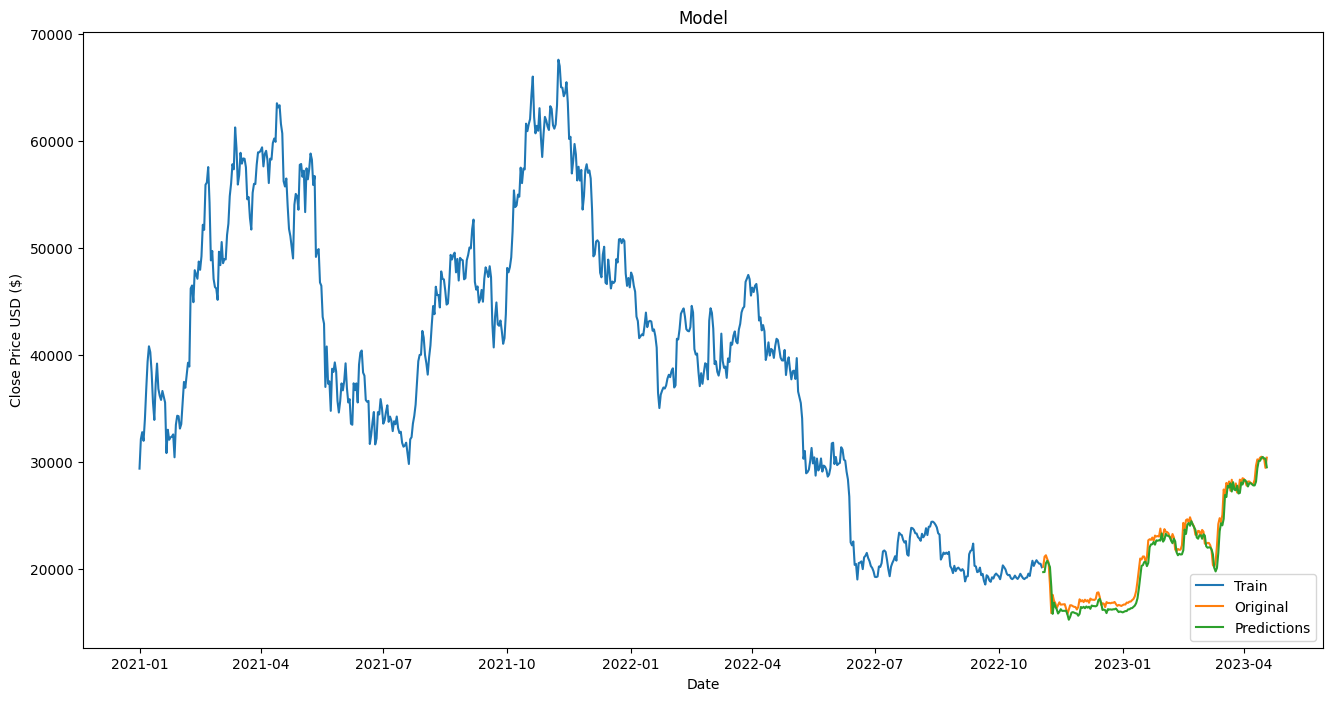

In [51]:
data = BTC_quant.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Original', 'Predictions'], loc='lower right')
plt.show()

In [54]:
## Predict tommorrow price ##
stock_quote = yf.download('BTC-USD', start='2021-01-01', end='2023-04-19')

new_df=stock_quote.filter(['Close'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of BTC-USD tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Price of BTC-USD tomorrow:[[30283.082]]


In [97]:
def predict_and_plot_btc_prices(num_days_to_predict):
  today = datetime.date.today()
  stock_quote = yf.download('BTC-USD', start=today-datetime.timedelta(days=100), end=today)
  new_df=stock_quote.filter(['Close'])
  last_60_days = new_df[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  predictions = []
  predicted_dates = []
  for _ in range(num_days_to_predict):
    last_date = new_df.index[-1]
    # Create an empty list for the current iteration
    X_test = []

    # Append the past 60 days of scaled data
    X_test.append(last_60_days_scaled)

    # Convert the X_test data into a numpy array
    X_test = np.array(X_test)

    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Get the predicted scaled price
    pred_price = model.predict(X_test)

    # Undo the scaling
    pred_price_unscaled = scaler.inverse_transform(pred_price)

    # Add the unscaled predicted price to the list of predictions
    predictions.append(pred_price_unscaled[0][0])

    # Update last_60_days_scaled by removing the first day and adding the predicted price
    last_60_days_scaled = np.concatenate((last_60_days_scaled[1:], pred_price), axis=0)

    # Add the predicted date to the list of predicted_dates
    predicted_date = last_date + datetime.timedelta(days=_+1)
    predicted_dates.append(predicted_date)
  print(f"Price of BTC-USD for the next 3 trading days: {predictions}")
  fig, ax = plt.subplots()
  ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
  ax.set(xlabel='Date', ylabel='BTC-USD Price', title='Predicted BTC-USD Prices for the Next 3 Trading Days')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
  ax.set_xlim(predicted_dates[0], predicted_dates[0] + datetime.timedelta(days=num_days_to_predict))
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.show()

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 31ms/step
Price of BTC-USD for the next 3 trading days: [27426.43, 27276.277, 27125.242, 26966.438, 26799.87, 26625.475, 26443.223, 26253.018, 26054.69, 25848.016, 25632.744, 25408.598, 25175.287, 24932.525, 24680.025, 24417.51, 24144.71, 23861.371, 23567.246, 23262.104, 22945.74, 22617.967, 22278.629, 21927.592, 21564.76, 21190.076, 20803.523, 20405.139, 19995.006, 19573.26]


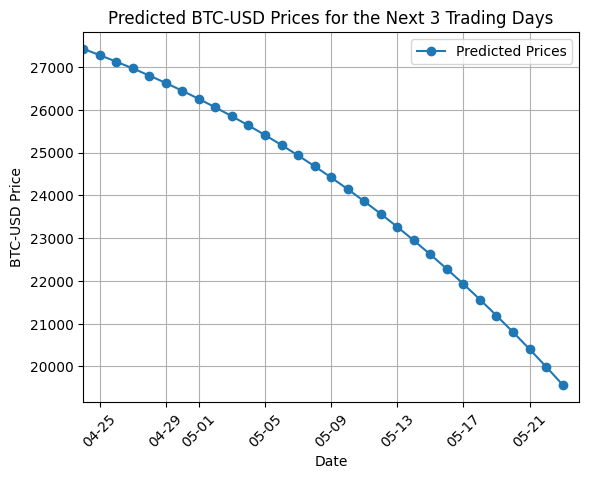

In [98]:
predict_and_plot_btc_prices(30)